- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [43]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
product_list = ["rb", "hc", "i", "j", "jm"]

In [4]:
period = 4096

In [5]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 969

969

In [6]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [7]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
out_sample = all_dates>="20190830"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [8]:
import dask
from dask import compute, delayed

In [9]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [10]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

class foctor_total_trade_imb_period(factor_template):
    factor_name = "total.trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)),1).values

class foctor_trade_imb_period(factor_template):
    factor_name = "trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"]), period, adjust=True).values

from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True))

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period).values
    
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values
    
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True).values

class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).values

from collections import OrderedDict
class foctor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))


from collections import OrderedDict
class foctor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]
    
from collections import OrderedDict
class foctor_volume_open_ratio_period(factor_template):
    factor_name = "volume.open.ratio.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(cum(data["qty"],period), cum(data["cum.open.int"]/period,period))

from collections import OrderedDict
class foctor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

def get_atr(file, product, period_list, spread):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, HEAD_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-12:])

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

- Now we generate all the signals one by one for the new data

In [11]:
x1 = foctor_trade_imb_period()
x2 = foctor_total_trade_imb_period()
x3 = foctor_nr_period()
x4 = foctor_dbook_period()
x5 = foctor_range_pos_period()
x6 = foctor_price_osci_period()
x7 = foctor_ma_diff_period()
x8 = foctor_kdj_j_period()
x9 = foctor_kdj_k_period()
x10 = foctor_range_period()
x11 = foctor_std_period()
x12 = foctor_volume_open_ratio_period()
x13 = foctor_trend_index_period()

In [12]:
product = "rb"
new_dates = all_dates[all_dates>="20190830"]
new_dates.sort()
len(new_dates)

54

In [19]:
%%time
i = 0
all_signal_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
for xx in all_signal_list:
    for product in product_list:
        print("signal ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)
    i = i + 1
# signal  0 rb
# signal  0 hc
# signal  0 i
# signal  0 j
# signal  0 jm
# signal  1 rb
# signal  1 hc
# signal  1 i
# signal  1 j
# signal  1 jm
# signal  2 rb
# signal  2 hc
# signal  2 i
# signal  2 j
# signal  2 jm
# signal  3 rb
# signal  3 hc
# signal  3 i
# signal  3 j
# signal  3 jm
# signal  4 rb
# signal  4 hc
# signal  4 i
# signal  4 j
# signal  4 jm
# signal  5 rb
# signal  5 hc
# signal  5 i
# signal  5 j
# signal  5 jm
# signal  6 rb
# signal  6 hc
# signal  6 i
# signal  6 j
# signal  6 jm
# signal  7 rb
# signal  7 hc
# signal  7 i
# signal  7 j
# signal  7 jm
# signal  8 rb
# signal  8 hc
# signal  8 i
# signal  8 j
# signal  8 jm
# signal  9 rb
# signal  9 hc
# signal  9 i
# signal  9 j
# signal  9 jm
# signal  10 rb
# signal  10 hc
# signal  10 i
# signal  10 j
# signal  10 jm
# signal  11 rb
# signal  11 hc
# signal  11 i
# signal  11 j
# signal  11 jm
# signal  12 rb
# signal  12 hc
# signal  12 i
# signal  12 j
# signal  12 jm
# Wall time: 10min 36s


signal  0 rb
signal  0 hc
signal  0 i
signal  0 j
signal  0 jm
signal  1 rb
signal  1 hc
signal  1 i
signal  1 j
signal  1 jm
signal  2 rb
signal  2 hc
signal  2 i
signal  2 j
signal  2 jm
signal  3 rb
signal  3 hc
signal  3 i
signal  3 j
signal  3 jm
signal  4 rb
signal  4 hc
signal  4 i
signal  4 j
signal  4 jm
signal  5 rb
signal  5 hc
signal  5 i
signal  5 j
signal  5 jm
signal  6 rb
signal  6 hc
signal  6 i
signal  6 j
signal  6 jm
signal  7 rb
signal  7 hc
signal  7 i
signal  7 j
signal  7 jm
signal  8 rb
signal  8 hc
signal  8 i
signal  8 j
signal  8 jm
signal  9 rb
signal  9 hc
signal  9 i
signal  9 j
signal  9 jm
signal  10 rb
signal  10 hc
signal  10 i
signal  10 j
signal  10 jm
signal  11 rb
signal  11 hc
signal  11 i
signal  11 j
signal  11 jm
signal  12 rb
signal  12 hc
signal  12 i
signal  12 j
signal  12 jm
Wall time: 10min 36s


In [20]:
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "volume.open.ratio", "trend.index"]
period_list = np.power(2, range(10,13))

In [13]:
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class foctor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period"
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values
    xx = foctor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = [DATA_PATH+product+"/"+date for date in date_list]
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)

In [23]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, new_dates, product_list, HEAD_PATH)

## Wall time: 26min 59s

d:/intern/tmp pkl/rb/trade.imb.range.1024
d:/intern/tmp pkl/rb/trade.imb.range.2048
d:/intern/tmp pkl/rb/trade.imb.range.4096
d:/intern/tmp pkl/hc/trade.imb.range.1024
d:/intern/tmp pkl/hc/trade.imb.range.2048
d:/intern/tmp pkl/hc/trade.imb.range.4096
d:/intern/tmp pkl/i/trade.imb.range.1024
d:/intern/tmp pkl/i/trade.imb.range.2048
d:/intern/tmp pkl/i/trade.imb.range.4096
d:/intern/tmp pkl/j/trade.imb.range.1024
d:/intern/tmp pkl/j/trade.imb.range.2048
d:/intern/tmp pkl/j/trade.imb.range.4096
d:/intern/tmp pkl/jm/trade.imb.range.1024
d:/intern/tmp pkl/jm/trade.imb.range.2048
d:/intern/tmp pkl/jm/trade.imb.range.4096
d:/intern/tmp pkl/rb/total.trade.imb.range.1024
d:/intern/tmp pkl/rb/total.trade.imb.range.2048
d:/intern/tmp pkl/rb/total.trade.imb.range.4096
d:/intern/tmp pkl/hc/total.trade.imb.range.1024
d:/intern/tmp pkl/hc/total.trade.imb.range.2048
d:/intern/tmp pkl/hc/total.trade.imb.range.4096
d:/intern/tmp pkl/i/total.trade.imb.range.1024
d:/intern/tmp pkl/i/total.trade.imb.range

In [24]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(10,13)), spread=spread) 


Wall time: 25.3 s


In [25]:
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [26]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")

# Wall time: 8min 7s

Wall time: 8min 7s


In [52]:
def par_get_signal_mat(file_name, product, signal_list, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file_name)
    signal_mat = functools.reduce(functools.partial(get_signal_mat, product=product, file_name=file_name), signal_list, None)
    save(signal_mat, SAVE_PATH+"/signal mat pkl/"+product+"/"+file_name)

In [53]:
%%time
for product in product_list:
    print(product)
    parLapply(CORE_NUM, new_dates, par_get_signal_mat, 
              product=product, signal_list=signal_list, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern")

rb
hc
i
j
jm
Wall time: 1min 44s


- we test several models:
- in-sample/out-sample lasso of week 9
- rolling lasso of week 9
- medium frequency lasso of week 11

In [39]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

In [40]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [41]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in ["hc","j","jm"]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

rb (5266, 48)
hc (3894, 48)
j (3118, 48)
jm (2999, 48)


In [42]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [43]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = model.coef_/x_std
print(fit_coef)

[-0.         -0.          0.01571216 -0.00036018  0.          0.0112997
 -0.          0.         -0.         -0.         -0.          0.
 -0.01278658 -0.         -0.          0.          0.         -0.
 -0.00746176 -0.00949664  0.         -0.         -0.01548164 -0.
  0.          0.         -0.         -0.          0.          0.00115205
 -0.02323864 -0.          0.          0.          0.         -0.
 -0.00137254  0.          0.         -0.00331034  0.          0.00530771
  0.          0.          0.        ]


In [44]:
coef_list=dict([])
for product in ["rb","hc","j","jm"]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef)

rb
trade.imb.4096                           -0.000000
total.trade.imb.4096                     -0.000000
nr.4096                                   0.002800
dbook.4096                               -0.000037
range.pos.4096                            0.000000
price.osci.4096                           0.000112
ma.dif.10.4096                           -0.000000
kdj.k.4096                                0.000000
kdj.j.4096                               -0.000000
trade.imb.range.4096                     -0.000000
total.trade.imb.range.4096               -0.000000
nr.range.4096                             0.000000
dbook.range.4096                         -0.000048
range.pos.range.4096                     -0.000000
price.osci.range.4096                    -0.000000
ma.dif.10.range.4096                      0.000000
kdj.k.range.4096                          0.000000
kdj.j.range.4096                         -0.000000
trade.imb.std.4096                       -0.000171
total.trade.imb.std.4096    

In [57]:
product = "i"
train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
coef = model.coef_/x_std
print(product)
print(coef)
coef_list[product] = coef

i
[ 6.16585396e-03  0.00000000e+00  4.31578629e-04  4.34389078e-04
 -0.00000000e+00  6.93773884e-04 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.53884434e-04 -0.00000000e+00
  0.00000000e+00 -1.69604492e-04 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -1.27386213e-03 -0.00000000e+00
 -0.00000000e+00 -2.67209310e-03 -0.00000000e+00 -0.00000000e+00
 -3.82280516e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.38191983e-03
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.85735676e-03 -0.00000000e+00
 -0.00000000e+00 -3.40377938e-05 -0.00000000e+00  6.04154454e-04
 -0.00000000e+00]


In [54]:
strat = "overall.lasso.002."+str(period)
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
    
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [58]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, new_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern")

rb
hc
i
j
jm
Wall time: 46.1 s


In [75]:
def get_good(date, product, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+date)
    good = data["good"]
    save(good, SAVE_PATH+"/good pkl/"+product+"/"+date)  

In [76]:
%%time
for product in product_list:
    parLapply(CORE_NUM, new_dates, get_good, product=product, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern")

Wall time: 24.6 s


In [80]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH="e:/intern")

Wall time: 53.8 s


In [81]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("overall.lasso.002", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SIGNAL_PATH="e:/intern",
                    period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 5min 37s

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 37s


rb train sharpe  1.1442575971000764 test sharpe  1.6513219700396344
hc train sharpe  1.4055326206854022 test sharpe  0.5056122071678995
i train sharpe  0.9992070222655217 test sharpe  0.45400224497961406
j train sharpe  1.8537677926697727 test sharpe  1.4913458517171523
jm train sharpe  1.1712285855458766 test sharpe  0.5836506829522072
out sharpe:  1.5148999762719026


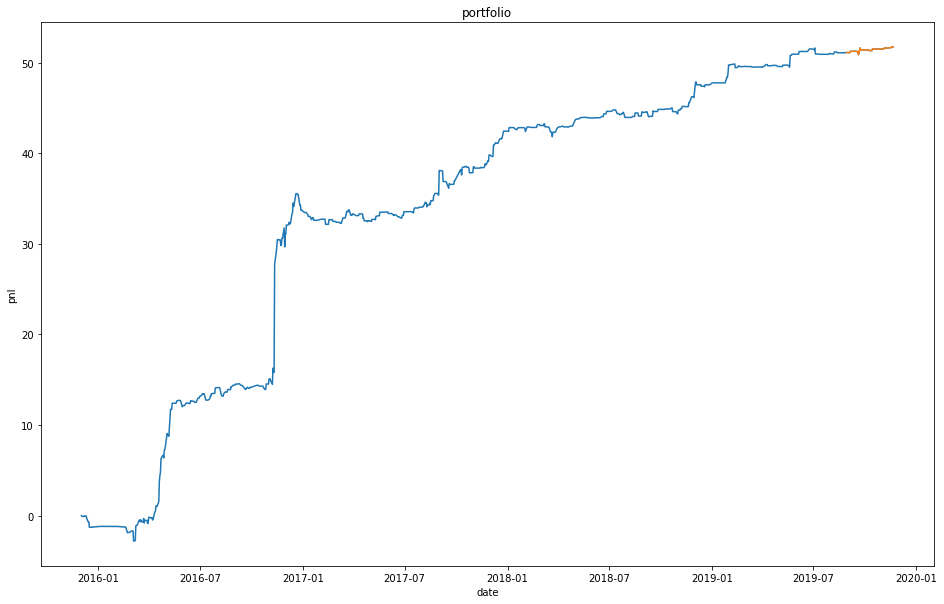

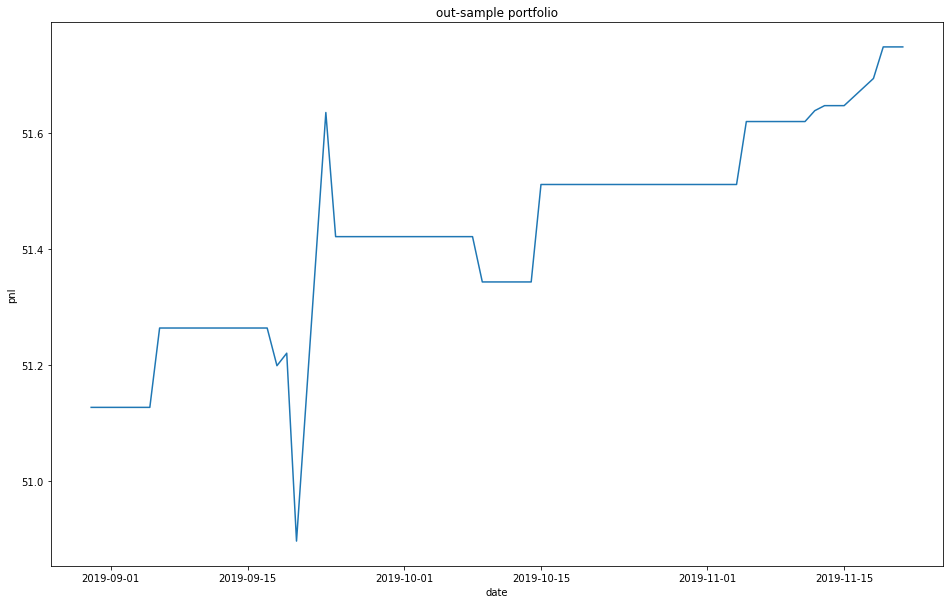

In [85]:
i = 0
strat = "overall.lasso.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
out_portfolio = all_portfolio[out_sample]
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[out_sample], all_portfolio.cumsum()[out_sample])
print("out sharpe: ", sharpe(out_portfolio))
plt.figure(2, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("out-sample portfolio");
plt.plot(format_dates[out_sample], all_portfolio.cumsum()[out_sample])

# rb train sharpe  1.1442575971000764 test sharpe  1.6513219700396344
# hc train sharpe  1.4055326206854022 test sharpe  0.5056122071678995
# i train sharpe  0.9992070222655217 test sharpe  0.45400224497961406
# j train sharpe  1.8537677926697727 test sharpe  1.4913458517171523
# jm train sharpe  1.1712285855458766 test sharpe  0.5836506829522072
# out sharpe:  1.5148999762719026



- we can see that the out-sample portfolio is quite good
- now we go to the rolling lasso model

In [87]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2018")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [15]:
month = np.array([file[:6] for file in all_dates])
month_len = np.unique(month, return_counts=True)
month_len

# (array(['201512', '201601', '201602', '201603', '201604', '201605',
#         '201606', '201607', '201608', '201609', '201610', '201611',
#         '201612', '201701', '201702', '201703', '201704', '201705',
#         '201706', '201707', '201708', '201709', '201710', '201711',
#         '201712', '201801', '201802', '201803', '201804', '201805',
#         '201806', '201807', '201808', '201809', '201810', '201811',
#         '201812', '201901', '201902', '201903', '201904', '201905',
#         '201906', '201907', '201908', '201909', '201910', '201911'],
#        dtype='<U6'),
#  array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
#         20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
#         18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18, 15],
#        dtype=int64))

(array(['201512', '201601', '201602', '201603', '201604', '201605',
        '201606', '201607', '201608', '201609', '201610', '201611',
        '201612', '201701', '201702', '201703', '201704', '201705',
        '201706', '201707', '201708', '201709', '201710', '201711',
        '201712', '201801', '201802', '201803', '201804', '201805',
        '201806', '201807', '201808', '201809', '201810', '201811',
        '201812', '201901', '201902', '201903', '201904', '201905',
        '201906', '201907', '201908', '201909', '201910', '201911'],
       dtype='<U6'),
 array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
        20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
        18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18, 15],
       dtype=int64))

In [16]:
test_range = month_len[0] > "2018"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])
month_len[1][test_range]

array([22, 15, 22, 18, 22, 20, 22, 23, 19, 18, 22, 20, 22, 15, 21, 21, 20,
       19, 23, 22, 20, 18, 15], dtype=int64)

In [46]:
new_start = np.where(month_len[0]>="201908")[0][0]
new_start
## 44

44

In [18]:
month_len[0][test_range]

# array(['201801', '201802', '201803', '201804', '201805', '201806',
#        '201807', '201808', '201809', '201810', '201811', '201812',
#        '201901', '201902', '201903', '201904', '201905', '201906',
#        '201907', '201908', '201909', '201910', '201911'], dtype='<U6')

array(['201801', '201802', '201803', '201804', '201805', '201806',
       '201807', '201808', '201809', '201810', '201811', '201812',
       '201901', '201902', '201903', '201904', '201905', '201906',
       '201907', '201908', '201909', '201910', '201911'], dtype='<U6')

In [92]:
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample])
    n_days = sum(sample)
    n_signal = len(signal_list)
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        chosen = (np.arange(sum(data["good"]))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            S = S[data["good"]]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [95]:
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
    
y1 = foctor_ret_period()
class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
    
y2 = foctor_ret_period_002()
class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
    
y3 = foctor_ret_period_001()

In [96]:
%%time
i = 0
all_pred_list = [y1,y2,y3]
for xx in all_pred_list:
    for product in product_list:
        print("pred ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)
    i = i + 1
    
# pred  0 rb
# pred  0 hc
# pred  0 i
# pred  0 j
# pred  0 jm
# pred  1 rb
# pred  1 hc
# pred  1 i
# pred  1 j
# pred  1 jm
# pred  2 rb
# pred  2 hc
# pred  2 i
# pred  2 j
# pred  2 jm
# Wall time: 2min 26s


pred  0 rb
pred  0 hc
pred  0 i
pred  0 j
pred  0 jm
pred  1 rb
pred  1 hc
pred  1 i
pred  1 j
pred  1 jm
pred  2 rb
pred  2 hc
pred  2 i
pred  2 j
pred  2 jm
Wall time: 2min 26s


In [19]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    out_mat = get_sample_signal(all_dates, out_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002"]), 
                                  period, daily_num)
    save(out_mat, HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")

# rb
# hc
# i
# j
# jm
# Wall time: 3min


rb
hc
i
j
jm
Wall time: 3min


In [31]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    out_mat = load(HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [21]:
from sklearn.preprocessing import StandardScaler

In [27]:
test_range = np.where(month_len[0] > "2018" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])

['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
 '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
 '201905' '201906' '201907' '201908' '201909' '201910' '201911']


In [45]:
test_range

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47], dtype=int64)

In [47]:
%%time
strat = "universal.lasso.002.4096"
y_signal = "ret.4096.002"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        get_multiple_lasso_roll_model(train_start, train_end, y_signal, n_signal, daily_ticks, all_mat, forward_len, strat+"."+month_len[0][i_test], 
                              ["i"], ["rb","hc","j","jm"], period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1
    
# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# Wall time: 25.6 s



25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
Wall time: 25.6 s


In [48]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
strat_name = "universal.lasso.002.4096"
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        strat_name = strat+"."+month_len[0][i_test]
        coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
        for product in product_list:
            coef = coef_list[product]
            os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
            parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                      product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

%%time

start_month = 0

SAVE_PATH = "e:/intern"

strat_name = "universal.lasso.002.4096"

end_month = sum(month_len[0] < "2018")-1

for i_test in test_range:

    forward_len = month_len[1][i_test]

    train_start = 0 if start_month==0 else cum_month_len[start_month-1]

    train_end = cum_month_len[end_month]-1

    print(i_test, month_len[0][i_test])

    if i_test>=new_start:

        strat_name = strat+"."+month_len[0][i_test]

        coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")

        for product in product_list:

            coef = coef_list[product]

            os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)

            parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 

                      product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern")

    start_month = start_month+1

    end_month = end_month+1


# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# Wall time: 1h 14min 1s


25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
Wall time: 1h 14min 1s


In [49]:
%%time
strat = "universal.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    if i_test>=new_start:
        for product in product_list:
            par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, HEAD_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201801 20151202.pkl 20171229.pkl
# 201802 20160104.pkl 20180131.pkl
# 201803 20160201.pkl 20180228.pkl
# 201804 20160301.pkl 20180330.pkl
# 201805 20160401.pkl 20180427.pkl
# 201806 20160503.pkl 20180531.pkl
# 201807 20160601.pkl 20180629.pkl
# 201808 20160701.pkl 20180731.pkl
# 201809 20160801.pkl 20180831.pkl
# 201810 20160901.pkl 20180928.pkl
# 201811 20161010.pkl 20181031.pkl
# 201812 20161101.pkl 20181130.pkl
# 201901 20161201.pkl 20181228.pkl
# 201902 20170103.pkl 20190131.pkl
# 201903 20170203.pkl 20190228.pkl
# 201904 20170301.pkl 20190329.pkl
# 201905 20170405.pkl 20190430.pkl
# 201906 20170502.pkl 20190531.pkl
# 201907 20170601.pkl 20190628.pkl
# 201908 20170703.pkl 20190731.pkl
# 201909 20170801.pkl 20190830.pkl
# 201910 20170901.pkl 20190930.pkl
# 201911 20171009.pkl 20191031.pkl
# Wall time: 4min 6s

201801 20151202.pkl 20171229.pkl
201802 20160104.pkl 20180131.pkl
201803 20160201.pkl 20180228.pkl
201804 20160301.pkl 20180330.pkl
201805 20160401.pkl 20180427.pkl
201806 20160503.pkl 20180531.pkl
201807 20160601.pkl 20180629.pkl
201808 20160701.pkl 20180731.pkl
201809 20160801.pkl 20180831.pkl
201810 20160901.pkl 20180928.pkl
201811 20161010.pkl 20181031.pkl
201812 20161101.pkl 20181130.pkl
201901 20161201.pkl 20181228.pkl
201902 20170103.pkl 20190131.pkl
201903 20170203.pkl 20190228.pkl
201904 20170301.pkl 20190329.pkl
201905 20170405.pkl 20190430.pkl
201906 20170502.pkl 20190531.pkl
201907 20170601.pkl 20190628.pkl
201908 20170703.pkl 20190731.pkl
201909 20170801.pkl 20190830.pkl
201910 20170901.pkl 20190930.pkl
201911 20171009.pkl 20191031.pkl
Wall time: 4min 6s


In [50]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2018")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        if i_test>=new_start:
            all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
            open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
            thre_list = []
            for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
                thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
            thre_list = np.array(thre_list)
            thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
            train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                                 product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                                 max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
            test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                                product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                                 max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            test_stat = get_hft_summary(test_result, thre_mat, forward_len)
            stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
            save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [51]:
%%time
strat = "universal.lasso.002.4096"
for product in product_list:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=20)

# rb 25 universal.lasso.002.4096.201801
# rb 26 universal.lasso.002.4096.201802
# rb 27 universal.lasso.002.4096.201803
# rb 28 universal.lasso.002.4096.201804
# rb 29 universal.lasso.002.4096.201805
# rb 30 universal.lasso.002.4096.201806
# rb 31 universal.lasso.002.4096.201807
# rb 32 universal.lasso.002.4096.201808
# rb 33 universal.lasso.002.4096.201809
# rb 34 universal.lasso.002.4096.201810
# rb 35 universal.lasso.002.4096.201811
# rb 36 universal.lasso.002.4096.201812
# rb 37 universal.lasso.002.4096.201901
# rb 38 universal.lasso.002.4096.201902
# rb 39 universal.lasso.002.4096.201903
# rb 40 universal.lasso.002.4096.201904
# rb 41 universal.lasso.002.4096.201905
# rb 42 universal.lasso.002.4096.201906
# rb 43 universal.lasso.002.4096.201907
# rb 44 universal.lasso.002.4096.201908
# rb 45 universal.lasso.002.4096.201909
# rb 46 universal.lasso.002.4096.201910
# rb 47 universal.lasso.002.4096.201911
# hc 25 universal.lasso.002.4096.201801
# hc 26 universal.lasso.002.4096.201802
# hc 27 universal.lasso.002.4096.201803
# hc 28 universal.lasso.002.4096.201804
# hc 29 universal.lasso.002.4096.201805
# hc 30 universal.lasso.002.4096.201806
# hc 31 universal.lasso.002.4096.201807
# hc 32 universal.lasso.002.4096.201808
# hc 33 universal.lasso.002.4096.201809
# hc 34 universal.lasso.002.4096.201810
# hc 35 universal.lasso.002.4096.201811
# hc 36 universal.lasso.002.4096.201812
# hc 37 universal.lasso.002.4096.201901
# hc 38 universal.lasso.002.4096.201902
# hc 39 universal.lasso.002.4096.201903
# hc 40 universal.lasso.002.4096.201904
# hc 41 universal.lasso.002.4096.201905
# hc 42 universal.lasso.002.4096.201906
# hc 43 universal.lasso.002.4096.201907
# hc 44 universal.lasso.002.4096.201908
# hc 45 universal.lasso.002.4096.201909
# hc 46 universal.lasso.002.4096.201910
# hc 47 universal.lasso.002.4096.201911
# i 25 universal.lasso.002.4096.201801
# i 26 universal.lasso.002.4096.201802
# i 27 universal.lasso.002.4096.201803
# i 28 universal.lasso.002.4096.201804
# i 29 universal.lasso.002.4096.201805
# i 30 universal.lasso.002.4096.201806
# i 31 universal.lasso.002.4096.201807
# i 32 universal.lasso.002.4096.201808
# i 33 universal.lasso.002.4096.201809
# i 34 universal.lasso.002.4096.201810
# i 35 universal.lasso.002.4096.201811
# i 36 universal.lasso.002.4096.201812
# i 37 universal.lasso.002.4096.201901
# i 38 universal.lasso.002.4096.201902
# i 39 universal.lasso.002.4096.201903
# i 40 universal.lasso.002.4096.201904
# i 41 universal.lasso.002.4096.201905
# i 42 universal.lasso.002.4096.201906
# i 43 universal.lasso.002.4096.201907
# i 44 universal.lasso.002.4096.201908
# i 45 universal.lasso.002.4096.201909
# i 46 universal.lasso.002.4096.201910
# i 47 universal.lasso.002.4096.201911
# j 25 universal.lasso.002.4096.201801
# j 26 universal.lasso.002.4096.201802
# j 27 universal.lasso.002.4096.201803
# j 28 universal.lasso.002.4096.201804
# j 29 universal.lasso.002.4096.201805
# j 30 universal.lasso.002.4096.201806
# j 31 universal.lasso.002.4096.201807
# j 32 universal.lasso.002.4096.201808
# j 33 universal.lasso.002.4096.201809
# j 34 universal.lasso.002.4096.201810
# j 35 universal.lasso.002.4096.201811
# j 36 universal.lasso.002.4096.201812
# j 37 universal.lasso.002.4096.201901
# j 38 universal.lasso.002.4096.201902
# j 39 universal.lasso.002.4096.201903
# j 40 universal.lasso.002.4096.201904
# j 41 universal.lasso.002.4096.201905
# j 42 universal.lasso.002.4096.201906
# j 43 universal.lasso.002.4096.201907
# j 44 universal.lasso.002.4096.201908
# j 45 universal.lasso.002.4096.201909
# j 46 universal.lasso.002.4096.201910
# j 47 universal.lasso.002.4096.201911
# jm 25 universal.lasso.002.4096.201801
# jm 26 universal.lasso.002.4096.201802
# jm 27 universal.lasso.002.4096.201803
# jm 28 universal.lasso.002.4096.201804
# jm 29 universal.lasso.002.4096.201805
# jm 30 universal.lasso.002.4096.201806
# jm 31 universal.lasso.002.4096.201807
# jm 32 universal.lasso.002.4096.201808
# jm 33 universal.lasso.002.4096.201809
# jm 34 universal.lasso.002.4096.201810
# jm 35 universal.lasso.002.4096.201811
# jm 36 universal.lasso.002.4096.201812
# jm 37 universal.lasso.002.4096.201901
# jm 38 universal.lasso.002.4096.201902
# jm 39 universal.lasso.002.4096.201903
# jm 40 universal.lasso.002.4096.201904
# jm 41 universal.lasso.002.4096.201905
# jm 42 universal.lasso.002.4096.201906
# jm 43 universal.lasso.002.4096.201907
# jm 44 universal.lasso.002.4096.201908
# jm 45 universal.lasso.002.4096.201909
# jm 46 universal.lasso.002.4096.201910
# jm 47 universal.lasso.002.4096.201911
# Wall time: 22min 41s

rb 25 universal.lasso.002.4096.201801
rb 26 universal.lasso.002.4096.201802
rb 27 universal.lasso.002.4096.201803
rb 28 universal.lasso.002.4096.201804
rb 29 universal.lasso.002.4096.201805
rb 30 universal.lasso.002.4096.201806
rb 31 universal.lasso.002.4096.201807
rb 32 universal.lasso.002.4096.201808
rb 33 universal.lasso.002.4096.201809
rb 34 universal.lasso.002.4096.201810
rb 35 universal.lasso.002.4096.201811
rb 36 universal.lasso.002.4096.201812
rb 37 universal.lasso.002.4096.201901
rb 38 universal.lasso.002.4096.201902
rb 39 universal.lasso.002.4096.201903
rb 40 universal.lasso.002.4096.201904
rb 41 universal.lasso.002.4096.201905
rb 42 universal.lasso.002.4096.201906
rb 43 universal.lasso.002.4096.201907
rb 44 universal.lasso.002.4096.201908
rb 45 universal.lasso.002.4096.201909
rb 46 universal.lasso.002.4096.201910
rb 47 universal.lasso.002.4096.201911
hc 25 universal.lasso.002.4096.201801
hc 26 universal.lasso.002.4096.201802
hc 27 universal.lasso.002.4096.201803
hc 28 univer

d:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


sharpe  2.8719160446376204


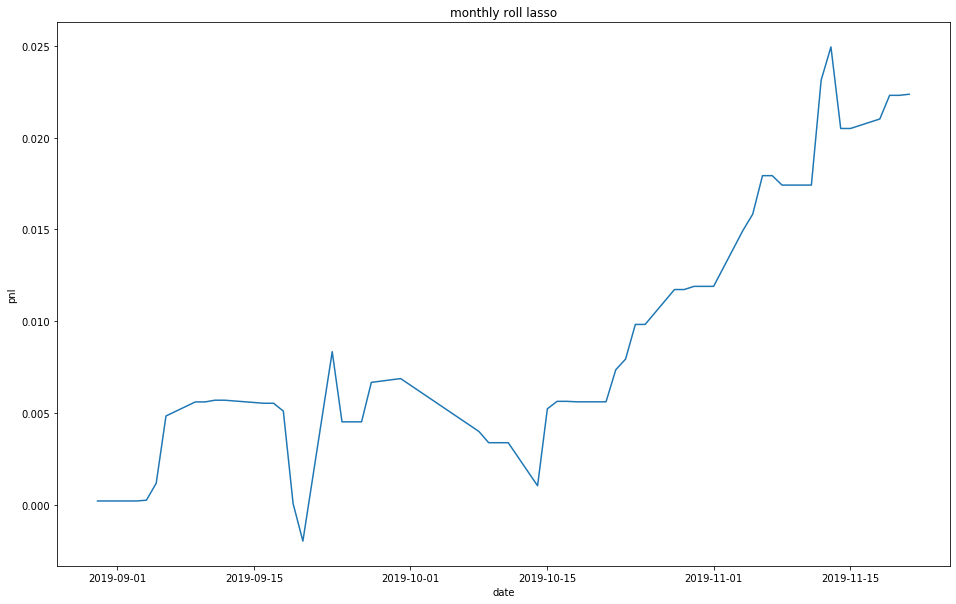

In [52]:
n_product = len(product_list)
save_path = "signal result atr"
strat = "universal.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
all_pnl = np.array([])
capital = 1e3
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
        train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl/capital
        test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/capital
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    avg_test_pnl = test_mat.mean(axis=1)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
out_pnl = all_pnl[-sum(out_sample):]
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[out_sample], out_pnl.cumsum());
print("sharpe ", sharpe(out_pnl))


- we can see that the result is pretty good!

- Congratulations! You have finished this course!
- Thank you very much for your participation! I wish you would enjoy taking this course!
- Happy trading in the future!